In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, MetaData, Table

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
metadata = MetaData()
metadata.reflect(bind=engine)

#automapBase
Base = automap_base(metadata=metadata)
Base.prepare()

#User = Base.classes.user
# reflect the tables
your_table = Table('station', metadata, autoload=True, autoload_with=engine)
your_table = Table('measurement', metadata, autoload=True, autoload_with=engine)


In [6]:
# View all of the classes that automap found
for class_name, table_class in Base.classes.items():
    print(f"Class Name: {class_name}")

Class Name: measurement
Class Name: station


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

most_recent_date = str(most_recent_date)

print(f"most_recent_date: {most_recent_date}")

most_recent_date: 2017-08-23


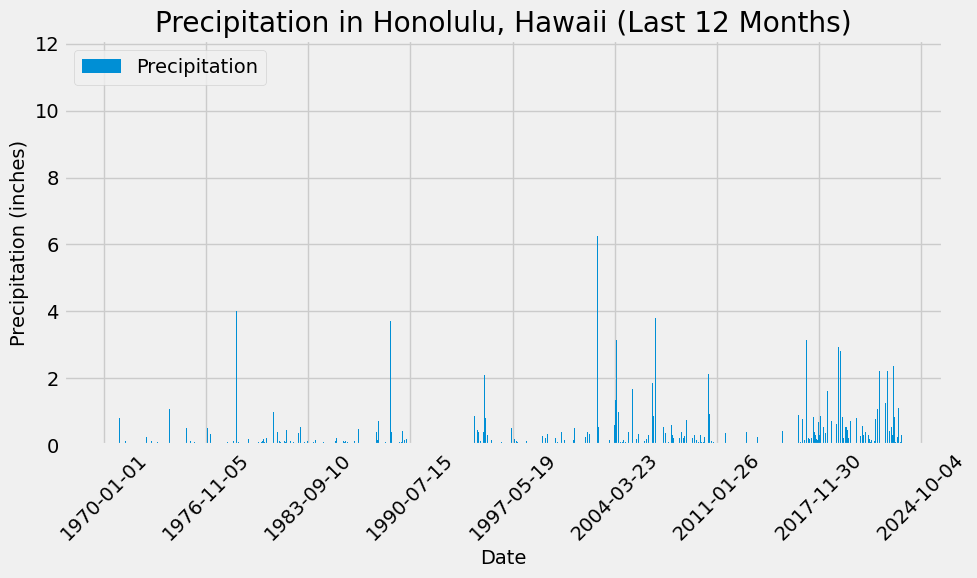

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

#print(precipitation_df)


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df.index, precipitation_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in Honolulu, Hawaii (Last 12 Months)')
plt.xticks(rotation=45)
date_format = mdates.DateFormatter("%Y-%m-%d")
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe()

print(summary_stats)

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(total_stations)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

print("Temperature Statistics for the most Active Station:")
for min_temp, max_temp, avg_temp in temperature_stats:
    print(f"Station ID: {most_active_station}")
    print(f"Lowest Temperature: {min_temp} F")
    print(f"Highest Temperature: {max_temp} F")
    print(f"Average Temperature: {avg_temp} F")

Temperature Statistics for the most Active Station:
Station ID: USC00519281
Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66378066378067 F


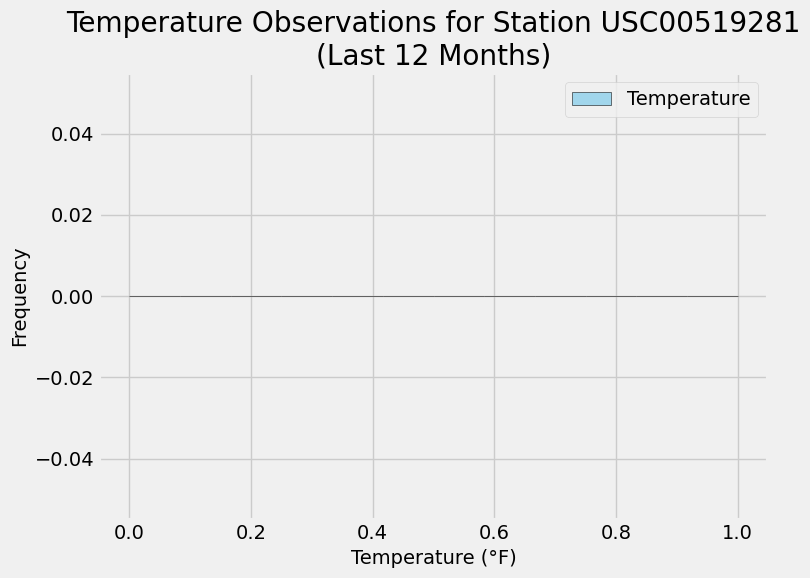

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#most_active_station = active_stations[0][0]

one_year_ago = datetime.now() - timedelta(days=365)
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Create a DataFrame from the query results
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, label='Temperature', alpha=0.75, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station}\n(Last 12 Months)')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()